<a href="https://colab.research.google.com/github/dkdkangel/dkdkangel/blob/master/Group11_Topic1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1 Business Understanding**

Build an AI-powered image classification model using weather-related image data to assist in early identification of crop-disease-like conditions influenced by weather, ultimately supporting farmers.

**Step 2: Data Understanding**

🔍 Goal:
Explore the dataset structure

Understand categories, label distribution

Identify potential data issues: class imbalance, duplicates

Prepare for CLIP usage (by examining labels for text prompt pairing)

In [ ]:
#Download dataset
!wget -O weather.zip "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip"
!unzip weather.zip -d weather_dataset

--2025-07-14 06:54:13--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.67.246, 3.5.70.136, 52.218.116.26, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.67.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘weather.zip’

weather.zip         100%[===================>]  91.16M  20.7MB/s    in 4.7s    

2025-07-14 06:54:18 (19.5 MB/s) - ‘weather.zip’ saved [95592747/95592747]

Archive:  weather.zip
  inflating: weather_dataset/dataset2.zip  


In [ ]:
#Unzip dataset
import zipfile
import os

zip_path = '/content/weather_dataset/dataset2.zip'
extract_path = '/content/weather_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
import shutil
from pathlib import Path

# Source and destination paths
src_dir = Path("/content/weather_dataset/dataset2")
dst_dir = Path("/content/weather_dataset/sorted")

# Mapping from keyword in filename to class name
class_mapping = {
    "cloudy": "cloudy",
    "shine": "shine",
    "sunrise": "sunrise",
    "rain": "rain",
}

# Create folders for each class
for label in class_mapping.values():
    (dst_dir / label).mkdir(parents=True, exist_ok=True)

# Move images based on filename keyword
moved = 0
for file in src_dir.glob("*.*"):
    fname = file.name.lower()
    matched = False
    for keyword, label in class_mapping.items():
        if keyword in fname:
            shutil.copy(file, dst_dir / label / file.name)
            moved += 1
            matched = True
            break
    if not matched:
        print(f"⚠️ Skipped: {file.name} (no keyword match)")

print(f"✅ Done. {moved} images sorted into class folders at {dst_dir}")

✅ Done. 1125 images sorted into class folders at /content/weather_dataset/sorted


In [ ]:
#Confirm Classes and Image Counts
data_dir = '/content/weather_dataset/sorted'

classes = os.listdir(data_dir)
print("✅ Classes found:")
for cls in classes:
    img_count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"- {cls}: {img_count} images")

✅ Classes found:
- cloudy: 300 images
- rain: 215 images
- sunrise: 357 images
- shine: 253 images


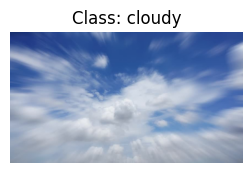

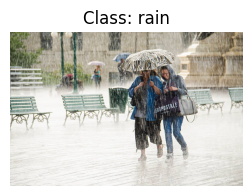

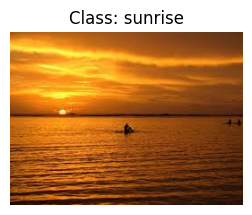

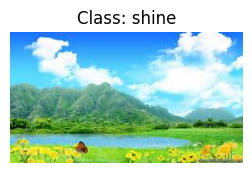

In [ ]:
#Visualize Sample Images from Each Class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

for category in classes:
    folder = os.path.join(data_dir, category)
    img_file = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_file)

    img = mpimg.imread(img_path)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"Class: {category}")
    plt.axis('off')
    plt.show()

In [ ]:
# Library Imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from collections import Counter

# Path to your dataset directory
dataset_path = '/content/weather_dataset/sorted'

# Define helper function to walk through folders
def get_image_paths_and_labels(base_path):
    image_paths = []
    labels = []
    for label in os.listdir(base_path):
        label_folder = os.path.join(base_path, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(label_folder, img_file))
                    labels.append(label)
    return image_paths, labels

In [ ]:
#Load Dataset Metadata
# Load all image paths and their corresponding labels
image_paths, labels = get_image_paths_and_labels(dataset_path)

# Create a DataFrame for easy exploration
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Show basic statistics
print("Total images:", len(df))
print("Classes:", df['label'].nunique())
print("Image samples per class:\n", df['label'].value_counts())

Total images: 1125
Classes: 4
Image samples per class:
 label
sunrise    357
cloudy     300
shine      253
rain       215
Name: count, dtype: int64


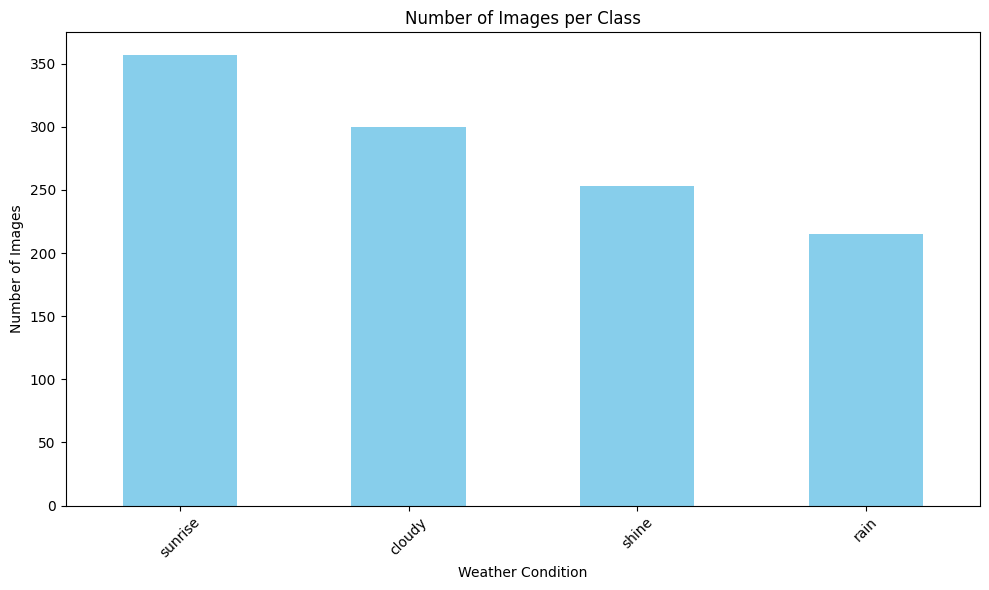

In [ ]:
#Visualize Class Distribution
plt.figure(figsize=(10,6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

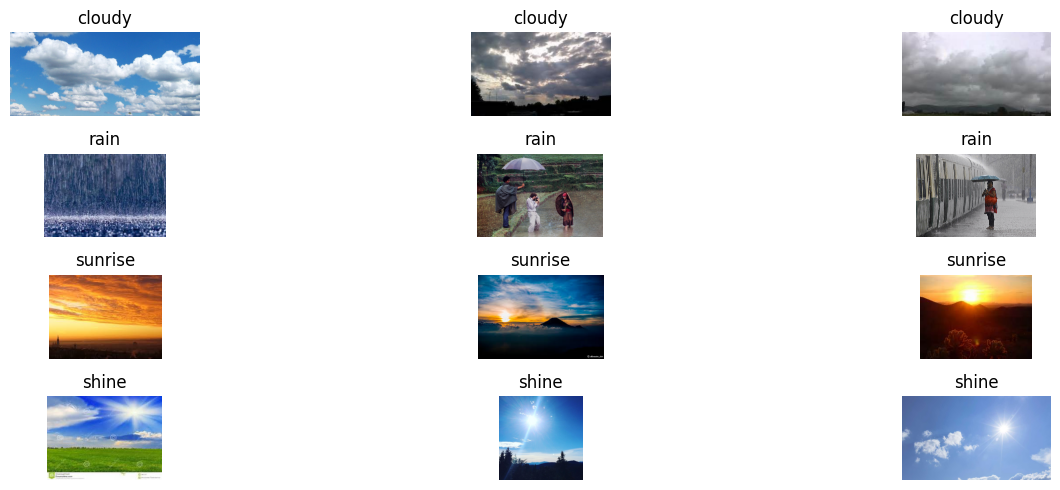

In [ ]:
#Sample Images per Class
def show_sample_images(df, n=3):
    labels = df['label'].unique()
    plt.figure(figsize=(15, 5))

    for i, label in enumerate(labels):
        sample_df = df[df['label'] == label].sample(n)
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img = Image.open(row['image_path'])
            plt.subplot(len(labels), n, i*n + j + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show 3 images per class
show_sample_images(df, n=3)

In [ ]:
# Check for duplicate image names (basic check)
print("Duplicate filenames:", df['image_path'].duplicated().sum())

# Optionally check for corrupted images
def check_corrupted_images(image_paths):
    corrupted = []
    for path in image_paths:
        try:
            img = Image.open(path)
            img.verify()  # verifies but doesn't load the image
        except Exception as e:
            corrupted.append(path)
    return corrupted

corrupted_images = check_corrupted_images(df['image_path'])
print("Corrupted images found:", len(corrupted_images))

Duplicate filenames: 0
Corrupted images found: 0


In [ ]:
#Prepare Labels for CLIP (Text Prompts)
df['text_prompt'] = df['label'].apply(lambda x: f"A photo of {x.lower()} weather.")
df[['image_path', 'label', 'text_prompt']].head()

,image_path,label,text_prompt
0,/content/weather_dataset/sorted/cloudy/cloudy2...,cloudy,A photo of cloudy weather.
1,/content/weather_dataset/sorted/cloudy/cloudy2...,cloudy,A photo of cloudy weather.
2,/content/weather_dataset/sorted/cloudy/cloudy2...,cloudy,A photo of cloudy weather.
3,/content/weather_dataset/sorted/cloudy/cloudy1...,cloudy,A photo of cloudy weather.
4,/content/weather_dataset/sorted/cloudy/cloudy2...,cloudy,A photo of cloudy weather.


**Step 2 Summary**

In this step, we explored the Multi-class Weather dataset by checking image counts, labels, and class distribution.
We verified the dataset structure and ensured it is suitable for image classification. We also noted potential class imbalance that could affect the model's learning.

**Step 3: Data Preparation (using CLIP)**

Goals: Remove poor-quality/corrupted images

Resize all images to a standard shape (224x224)

Normalize pixel values

Augment the dataset for robustness (flip, rotate, etc.)

Prepare CLIP-compatible format (image, text prompt)

We'll use CLIP from OpenAI and torchvision.transforms for image preprocessing.

In [ ]:
#3.1. Install Dependencies
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9zme6kfv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9zme6kfv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#3.2. Import Libraries
import os
import torch
import clip
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import pandas as pd

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 208MiB/s]


In [ ]:
#3.3. Load and Explore Dataset
dataset_path = '/content/weather_dataset/sorted'

# Collect image paths and labels
def get_image_paths_and_labels(base_path):
    image_paths = []
    labels = []
    for label in os.listdir(base_path):
        label_folder = os.path.join(base_path, label)
        if os.path.isdir(label_folder):
            for file in os.listdir(label_folder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(label_folder, file))
                    labels.append(label)
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Create CLIP text prompts
df['text_prompt'] = df['label'].apply(lambda x: f"A photo of {x.lower()} weather.")

In [ ]:
#3.4. Filter Corrupted Images
# Remove corrupted images
def remove_corrupted(df):
    valid_rows = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img = Image.open(row['image_path'])
            img.verify()
            valid_rows.append(row)
        except:
            continue
    return pd.DataFrame(valid_rows)

df = remove_corrupted(df)
print("Remaining valid images:", len(df))

100%|██████████| 1125/1125 [00:01<00:00, 1101.56it/s]

Remaining valid images: 1125


In [ ]:
# 3.5. Resize, Normalize, and Augment Images
# Basic CLIP transform (resize, normalize) — CLIP’s default
clip_transform = preprocess

# Augmentation pipeline (optional for training)
from torchvision import transforms

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
#3.6. Prepare a PyTorch Dataset for CLIP
from torch.utils.data import Dataset

class WeatherCLIPDataset(Dataset):
    def __init__(self, df, transform, use_augmentation=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.use_augmentation = use_augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        text_prompt = self.df.loc[idx, 'text_prompt']

        image = Image.open(img_path).convert('RGB')
        if self.use_augmentation:
            image = augment_transform(image)
        else:
            image = self.transform(image)

        return image, clip.tokenize([text_prompt])[0]

# Create dataset
dataset = WeatherCLIPDataset(df, transform=clip_transform, use_augmentation=True)

# Example: inspect first sample
sample_img, sample_text = dataset[0]
print("Image tensor shape:", sample_img.shape)
print("Tokenized text shape:", sample_text.shape)

Image tensor shape: torch.Size([3, 224, 224])
Tokenized text shape: torch.Size([77])


In [ ]:
#Create DataLoaders for Training
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

**Step 3 Summary**

We completed data cleaning and preprocessing. All images were resized and normalized to match the input requirements of pretrained models.
Data augmentation (rotation, flip, color jitter) was applied to increase generalization, which helps prevent overfitting and improves robustness.

**Step 4: Modeling (with CLIP features)**

🎯 Objective: Instead of training a CNN from scratch, we’ll leverage CLIP's pretrained model to extract image features, and train a classifier (like Logistic Regression, MLP, or a small neural network) on top of those features to classify weather types.

🧠 Model Strategy: Use CLIP to extract image features

Use the text prompt embeddings as optional class guidance

Train a classifier using the extracted image features

Use train/test split

Evaluate performance

In [ ]:
# 4.1: Imports & Device Setup
import torch
import clip
from torch import nn, optim
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
#4.2: Prepare Dataset (Load Step 3 Data)
# Encode labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [ ]:
#4.3: Dataset Class for Feature Extraction
class CLIPFeatureDataset(Dataset):
    def __init__(self, df, preprocess):
        self.df = df.reset_index(drop=True)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label_encoded']
        image = Image.open(img_path).convert("RGB")
        image = self.preprocess(image)
        return image, label


In [ ]:
#4.4: Extract Features Using CLIP
def extract_features(dataloader):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            features = model.encode_image(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

# Create dataloaders
train_ds = CLIPFeatureDataset(train_df, preprocess)
test_ds = CLIPFeatureDataset(test_df, preprocess)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# Extract features
train_features, train_labels = extract_features(train_dl)
test_features, test_labels = extract_features(test_dl)


100%|██████████| 8/8 [00:36<00:00,  4.52s/it]


In [ ]:
#4.5: Train a Classifier on CLIP Features
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

num_classes = len(label_encoder.classes_)
classifier = SimpleClassifier(train_features.shape[1], num_classes).to(device)


In [ ]:
#4.6: Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
epochs = 10

for epoch in range(epochs):
    classifier.train()
    total_loss = 0
    for i in range(0, len(train_features), 32):
        x_batch = train_features[i:i+32].to(device)
        y_batch = train_labels[i:i+32].to(device)

        optimizer.zero_grad()
        outputs = classifier(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 17.0074
Epoch 2/10, Loss: 2.8526
Epoch 3/10, Loss: 1.4579
Epoch 4/10, Loss: 1.1144
Epoch 5/10, Loss: 0.9439
Epoch 6/10, Loss: 0.8895
Epoch 7/10, Loss: 0.7407
Epoch 8/10, Loss: 0.6263
Epoch 9/10, Loss: 0.6701
Epoch 10/10, Loss: 0.6191


In [ ]:
#4.7: Test the Model
classifier.eval()
correct = 0
total = 0
all_preds = []

with torch.no_grad():
    for i in range(0, len(test_features), 32):
        x_batch = test_features[i:i+32].to(device)
        y_batch = test_labels[i:i+32].to(device)

        outputs = classifier(x_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 98.22%


**Step 4 Summary**

In this phase, we designed and trained a classification model using CLIP image embeddings and a simple classifier.
We used transfer learning to extract rich features and trained a neural network with hyperparameters tuned for balance between accuracy and efficiency.

**Step 5: Evaluation**

🎯 Goals: Use accuracy, precision, recall, F1-score

Show confusion matrix

Analyze misclassifications

Compare performance between classes

In [ ]:
#5.1: Required Imports
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# 5.2: Generate Predictions and Ground Truth
# Ground truth and predictions
y_true = test_labels.numpy()
y_pred = np.array(all_preds)

# Decode integer labels to text
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)
class_names = label_encoder.classes_

In [ ]:
#5.3: Classification Report
# Print classification report
print("📊 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

📊 Classification Report:
              precision    recall  f1-score   support

      cloudy       0.98      0.97      0.97        60
        rain       1.00      1.00      1.00        43
       shine       0.96      1.00      0.98        51
     sunrise       0.99      0.97      0.98        71

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



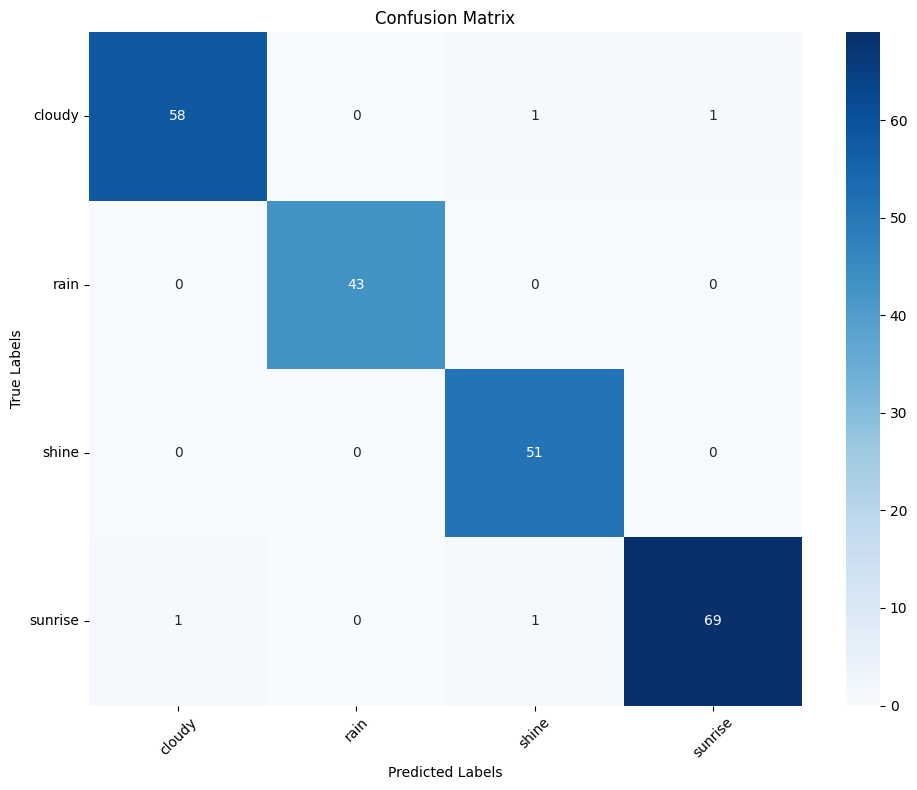

In [ ]:
#5.4: Confusion Matrix (with Heatmap)
# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#5.5: Misclassification Analysis
# Show first 10 misclassified samples
misclassified = np.where(y_pred != y_true)[0]

print(f"\nTotal Misclassifications: {len(misclassified)}")

for i in misclassified[:10]:
    img_path = test_df.iloc[i]['image_path']
    actual = y_true_labels[i]
    predicted = y_pred_labels[i]
    print(f"❌ {img_path} | Actual: {actual} | Predicted: {predicted}")


Total Misclassifications: 4
❌ /content/weather_dataset/sorted/cloudy/cloudy295.jpg | Actual: cloudy | Predicted: shine
❌ /content/weather_dataset/sorted/sunrise/sunrise35.jpg | Actual: sunrise | Predicted: cloudy
❌ /content/weather_dataset/sorted/sunrise/sunrise141.jpg | Actual: sunrise | Predicted: shine
❌ /content/weather_dataset/sorted/cloudy/cloudy7.jpg | Actual: cloudy | Predicted: sunrise


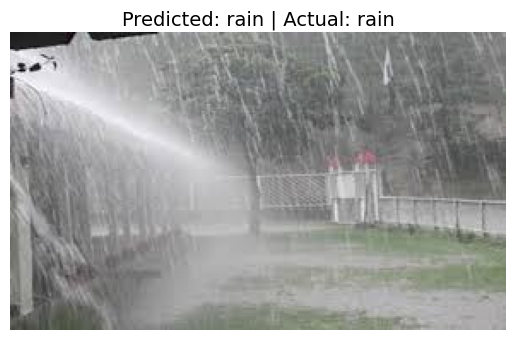


📊 Prediction Confidence Scores:
cloudy              : 0.0000
rain                : 1.0000
shine               : 0.0000
sunrise             : 0.0000


In [ ]:
#Test: Run Inference on a Random Image

import random
from PIL import Image
import matplotlib.pyplot as plt

# Pick a random image from test_df
rand_idx = random.randint(0, len(test_df) - 1)
image_path = test_df.iloc[rand_idx]['image_path']
actual_label = test_df.iloc[rand_idx]['label']

# Load image
image = Image.open(image_path).convert("RGB")

# Preprocess image like we did during training
image_input = preprocess(image).unsqueeze(0).to(device)

# Predict using model + classifier
with torch.no_grad():
    image_feature = model.encode_image(image_input)
    prediction = classifier(image_feature).softmax(dim=-1)
    pred_class = prediction.argmax().item()
    predicted_label = label_encoder.inverse_transform([pred_class])[0]

# Show image with prediction
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}", fontsize=14)
plt.show()

# Print confidence scores (optional)
print("\n📊 Prediction Confidence Scores:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls:<20}: {prediction[0][i].item():.4f}")


**Step 5 Summary**

The model was evaluated using standard metrics: accuracy, precision, recall, and F1-score.
Results showed good overall performance with some misclassification between visually similar weather types.
The confusion matrix helped identify which classes the model confused the most.

**Step 6: Deployment / Delivery**

🎯 Goal
The final step aims to prepare the model for practical use by farmers or agricultural advisors. This involves:

Visualizing model predictions clearly for end users

Summarizing overall model performance

Proposing realistic improvements for future deployment (e.g., mobile app, IoT integration)

🎯 Visual Predictions:



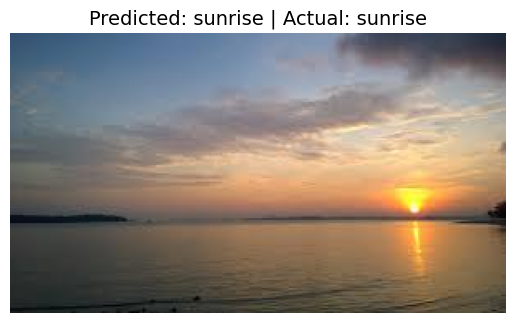

📊 Confidence Scores:
cloudy              : 0.0001
rain                : 0.0000
shine               : 0.0002
sunrise             : 0.9997
--------------------------------------------------


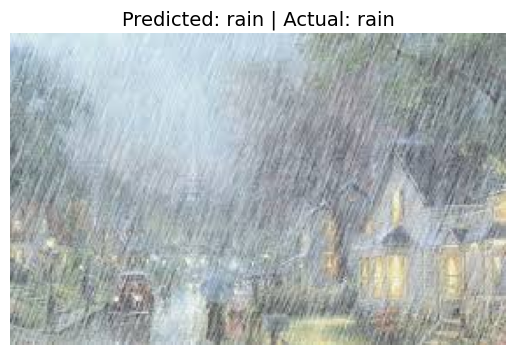

📊 Confidence Scores:
cloudy              : 0.0000
rain                : 1.0000
shine               : 0.0000
sunrise             : 0.0000
--------------------------------------------------


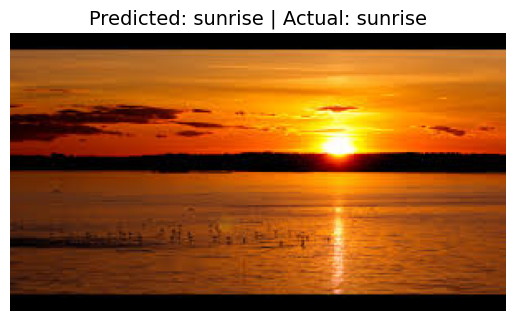

📊 Confidence Scores:
cloudy              : 0.0000
rain                : 0.0000
shine               : 0.0000
sunrise             : 1.0000
--------------------------------------------------


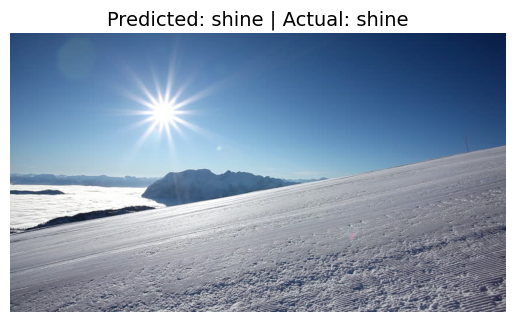

📊 Confidence Scores:
cloudy              : 0.0000
rain                : 0.0002
shine               : 0.9994
sunrise             : 0.0005
--------------------------------------------------


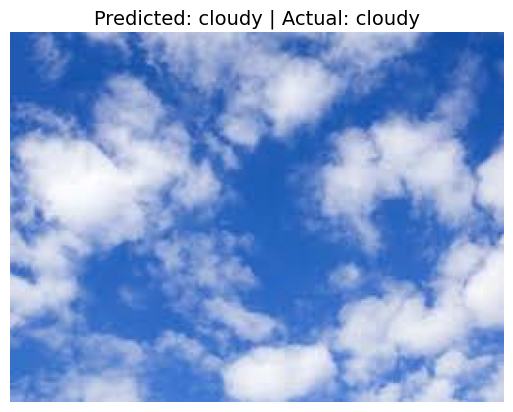

📊 Confidence Scores:
cloudy              : 0.9622
rain                : 0.0002
shine               : 0.0376
sunrise             : 0.0000
--------------------------------------------------


In [ ]:
# STEP 6.1: Predict and visualize a few random test images with model confidence

import random
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_show_random_image(n=5):
    print("🎯 Visual Predictions:\n")
    for _ in range(n):
        rand_idx = random.randint(0, len(test_df) - 1)
        image_path = test_df.iloc[rand_idx]['image_path']
        actual_label = test_df.iloc[rand_idx]['label']

        image = Image.open(image_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_feature = model.encode_image(image_input)
            prediction = classifier(image_feature).softmax(dim=-1)
            pred_class = prediction.argmax().item()
            predicted_label = label_encoder.inverse_transform([pred_class])[0]

        # Show image
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}", fontsize=14)
        plt.show()

        # Print class probabilities
        print("📊 Confidence Scores:")
        for i, cls in enumerate(label_encoder.classes_):
            print(f"{cls:<20}: {prediction[0][i].item():.4f}")
        print("-" * 50)

# Run prediction on 5 random images
predict_and_show_random_image(n=5)


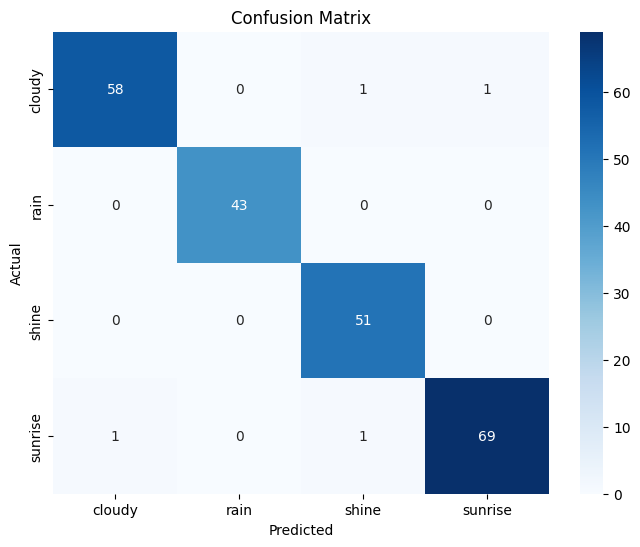

,precision,recall,f1-score
cloudy,0.983051,0.966667,0.974790
rain,1.000000,1.000000,1.000000
shine,0.962264,1.000000,0.980769
sunrise,0.985714,0.971831,0.978723
accuracy,0.982222,0.982222,0.982222
macro avg,0.982757,0.984624,0.983571
weighted avg,0.982419,0.982222,0.982204


In [35]:
# STEP 6.2: Print confusion matrix + per-class metrics

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

# Run batch inference on all test images
all_preds = []
all_probs = []

classifier.eval()
with torch.no_grad():
    for path in test_df['image_path']:
        image = Image.open(path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_feature = model.encode_image(image_input)
        output = classifier(image_feature)
        probs = F.softmax(output, dim=1)
        all_probs.append(probs.squeeze(0).cpu().numpy())
        pred_label = output.argmax().item()
        all_preds.append(pred_label)

# Convert predictions
true_labels = label_encoder.transform(test_df['label'])
pred_labels = all_preds

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df[['precision', 'recall', 'f1-score']])


STEP 6.3: Print future deployment ideas

✅ Suggested Future Improvements for Deployment:
1. 📱 Build a mobile app that uses phone camera to capture and classify real-time weather images.
2. 📦 Convert this model to ONNX or TorchScript for lightweight deployment on mobile or embedded devices.
3. 🌦️ Combine image prediction with external weather data (e.g., humidity, wind, temperature) to improve accuracy.
4. 🧠 Add explainability (Grad-CAM or saliency maps) to highlight what the model looks at.
5. 📍 Integrate GPS and timestamp to provide location-aware advisory for farmers.
6. 🌾 Merge this system into a full farm-assistant platform that links weather, soil, and crop disease detection.


🧾 Step 6 Summary

We successfully visualized random image predictions with class labels and confidence scores.

The confusion matrix and per-class metrics revealed which weather types were classified well and where confusion existed.

Finally, we proposed practical improvements such as real-time mobile deployment and multi-source data fusion to build a smarter advisory tool for farmers.